In [4]:
import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torch.utils.data as utils
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from torchvision.datasets import CIFAR10

%matplotlib inline

In [5]:
label_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]


def plot_images(images, cls_true, cls_pred=None):
    """
    Adapted from https://github.com/Hvass-Labs/TensorFlow-Tutorials/
    """
    fig, axes = plt.subplots(3, 3)

    for i, ax in enumerate(axes.flat):
        # plot img
        ax.imshow(images[i, :, :, :], interpolation='spline16')

        # show true & predicted classes
        cls_true_name = label_names[cls_true[i]]
        if cls_pred is None:
            xlabel = "{0} ({1})".format(cls_true_name, cls_true[i])
        else:
            cls_pred_name = label_names[cls_pred[i]]
            xlabel = "True: {0}\nPred: {1}".format(
                cls_true_name, cls_pred_name
            )
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..0.72156864].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..0.972549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..0.99607843].


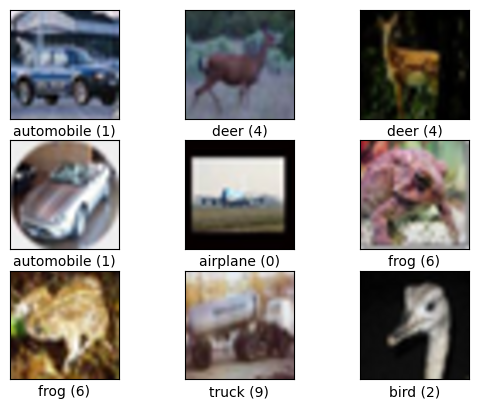

In [6]:
def get_train_valid_loader(data_dir='data',
                           batch_size=64,
                           augment=False,
                           random_seed=1,
                           valid_size=0.02,
                           shuffle=True,
                           show_sample=True,
                           num_workers=1,
                           pin_memory=True):
    """
    Utility function for loading and returning train and valid
    multi-process iterators over the CIFAR-10 dataset. A sample
    9x9 grid of the images can be optionally displayed.
    If using CUDA, num_workers should be set to 1 and pin_memory to True.
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to apply the data augmentation scheme
      mentioned in the paper. Only applied on the train split.
    - random_seed: fix seed for reproducibility.
    - valid_size: percentage split of the training set used for
      the validation set. Should be a float in the range [0, 1].
    - shuffle: whether to shuffle the train/validation indices.
    - show_sample: plot 9x9 sample grid of the dataset.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - train_loader: training set iterator.
    - valid_loader: validation set iterator.
    """
    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg

    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # define transforms for validation (no augmentation)
    valid_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])

    # Define the transform for training (and data augmentation)

    if augment:
        train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),  # Randomly flip images
            transforms.RandomCrop(32, padding=4),  # Randomly crop with padding
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color variations
            transforms.ToTensor(),
            normalize,
        ])
    else:
        train_transform = transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])

    # load the dataset
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=train_transform,
    )

    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=valid_transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )

    # visualize some images if requested
    if show_sample:
        sample_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=9, shuffle=shuffle,
            num_workers=num_workers, pin_memory=pin_memory,
        )
        data_iter = iter(sample_loader)
        images, labels = next(data_iter)
        # Unnormalize the images for display
        mean = [0.4914, 0.4822, 0.4465]
        std = [0.2023, 0.1994, 0.2010]
        unnorm_images = [unnormalize(img, mean, std) for img in images]
        X = torch.stack(unnorm_images).numpy().transpose([0, 2, 3, 1])
        plot_images(X, labels)

    return (train_loader, valid_loader)

def unnormalize(img, mean, std):
    img = img * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
    return img

trainloader, valloader = get_train_valid_loader()

# ResNet Architecture

In [22]:
class ResNetBlock(nn.Module):
    def __init__(self, channel_in, channel_out, stride=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(channel_in, channel_out, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channel_out)
        self.conv2 = nn.Conv2d(channel_out, channel_out, kernel_size=3, stride=1, padding=1, bias=False)    
        self.bn2 = nn.BatchNorm2d(channel_out)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or channel_in != channel_out:
            self.shortcut = nn.Sequential(
                nn.Conv2d(channel_in, channel_out, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(channel_out)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        
        out += self.shortcut(x)
        out = F.relu(out)
        
        return out
    
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet, self).__init__()
        
        self.in_channels = 32

        # Enter block
        self.in_conv = nn.Conv2d(3, self.in_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.in_bn = nn.BatchNorm2d(self.in_channels)
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual blocks
        self.layer1 = self._make_layer(block, 64, layers[1], stride=2)
        self.layer2 = self._make_layer(block, 128, layers[2], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[3], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)


        # Exit block
        self.out_bn = nn.BatchNorm2d(512)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

        self._init_weights()
    
    def _make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, channels, stride))
            self.in_channels = channels
        return nn.Sequential(*layers)
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = F.relu(self.in_bn(self.in_conv(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = F.relu(self.out_bn(x))
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def predict(self, x):
        logits = self.forward(x)
        return F.softmax(logits)


print("Model parameters: ", sum(p.numel() for p in ResNet(ResNetBlock, [2, 2, 2, 2]).parameters()))


Model parameters:  11157802


In [25]:
net = ResNet(ResNetBlock, [2, 2, 2, 2])
################################################################################
# TODO:                                                                        #
# Choose an Optimizer that will be used to minimize the loss function.         #
# Choose a critera that measures the loss                                      #
################################################################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

epochs = 20
steps = 0
running_loss = 0
print_every = 200
for e in range(epochs):
    start = time.time()
    for images, labels in iter(trainloader):

        steps += 1
        ################################################################################
        # TODO:                                                                        #
        # Run the training process                                                     #
        #                                                                              #
        #                                                                              #
        ################################################################################
        images, targets = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = net(images)

        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################

        loss = criterion(output, targets)
        ################################################################################
        # TODO:                                                                        #
        # Run the training process                                                     #
        #                                                                              #
        # HINT: Calculate the gradient and move one step further                       #
        ################################################################################
        
        loss.backward()
        optimizer.step()

        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################

        running_loss += loss.item()

        if steps % print_every == 0:
            stop = time.time()
            # Test accuracy
            accuracy = 0
            for ii, (images, labels) in enumerate(valloader):

                ################################################################################
                # TODO:                                                                        #
                # Calculate the accuracy                                                       #
                ################################################################################
                images, targets = images.to(device), labels.to(device)
                output = net(images)
                _, predicted = torch.max(output.data, 1)
                accuracy += (predicted == targets).sum().item()

                ################################################################################
                #                              END OF YOUR CODE                                #
                ################################################################################

            print("Epoch: {}/{}..".format(e+1, epochs),
                  "Loss: {:.4f}..".format(running_loss/print_every),
                  "Test accuracy: {:.4f}..".format(accuracy/(ii+1)),
                  "{:.4f} s/batch".format((stop - start)/print_every)
                 )
            running_loss = 0
            start = time.time()

Epoch: 1/20.. Loss: 2.9864.. Test accuracy: 24.6875.. 0.0096 s/batch
Epoch: 1/20.. Loss: 1.6534.. Test accuracy: 28.0000.. 0.0092 s/batch
Epoch: 1/20.. Loss: 1.4912.. Test accuracy: 31.3125.. 0.0091 s/batch
Epoch: 2/20.. Loss: 1.3553.. Test accuracy: 33.6250.. 0.0020 s/batch
Epoch: 2/20.. Loss: 1.2417.. Test accuracy: 36.0000.. 0.0092 s/batch
Epoch: 2/20.. Loss: 1.1867.. Test accuracy: 36.8750.. 0.0091 s/batch
Epoch: 2/20.. Loss: 1.1079.. Test accuracy: 37.9375.. 0.0091 s/batch
Epoch: 3/20.. Loss: 1.0555.. Test accuracy: 39.5625.. 0.0035 s/batch
Epoch: 3/20.. Loss: 0.9646.. Test accuracy: 38.9375.. 0.0091 s/batch
Epoch: 3/20.. Loss: 0.9699.. Test accuracy: 40.7500.. 0.0092 s/batch
Epoch: 3/20.. Loss: 0.9451.. Test accuracy: 40.1250.. 0.0092 s/batch
Epoch: 4/20.. Loss: 0.8678.. Test accuracy: 41.9375.. 0.0052 s/batch
Epoch: 4/20.. Loss: 0.8206.. Test accuracy: 42.8750.. 0.0095 s/batch
Epoch: 4/20.. Loss: 0.8124.. Test accuracy: 43.3750.. 0.0092 s/batch
Epoch: 4/20.. Loss: 0.8140.. Test 

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self, n_input_channels=3, n_output=10):
        super().__init__()
        
        self.conv1 = nn.Conv2d(n_input_channels, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, 3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.poof_end = nn.AdaptiveAvgPool2d((1, 1))  # Output (batch, 128, 1, 1)

        self.fc1 = nn.Linear(128 * 1 * 1, 256)  # Fix input size
        self.fc2 = nn.Linear(256, n_output)

        self.batchnorm1 = nn.BatchNorm2d(32)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.batchnorm4 = nn.BatchNorm2d(64)
        self.batchnorm5 = nn.BatchNorm2d(128)
        self.batchnorm6 = nn.BatchNorm2d(128)

        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.relu(self.batchnorm1(self.conv1(x)))
        x = self.pool(F.relu(self.batchnorm2(self.conv2(x))))
        x = self.dropout(x)

        x = F.relu(self.batchnorm3(self.conv3(x)))
        x = self.pool(F.relu(self.batchnorm4(self.conv4(x))))
        x = self.dropout(x)

        x = F.relu(self.batchnorm5(self.conv5(x)))
        x = self.poof_end(F.relu(self.batchnorm6(self.conv6(x))))  # Now (batch, 128, 1, 1)

        x = x.view(x.size(0), -1)  # Flatten dynamically

        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

    def predict(self, x):
        logits = self.forward(x)
        return F.softmax(logits, dim=1)  # Add dim=1 for correct softmax behavior

# Test the model
model = ConvNet()
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

# Debug with a sample input
x = torch.randn(1, 3, 32, 32)  # Batch size 1, 3 channels, 32x32 image
out = model(x)
print("Output shape:", out.shape)  # Should be [1, 10]


323,498 total parameters.
323,498 training parameters.
Output shape: torch.Size([1, 10])


In [50]:
net = ConvNet()
################################################################################
# TODO:                                                                        #
# Choose an Optimizer that will be used to minimize the loss function.         #
# Choose a critera that measures the loss                                      #
################################################################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

epochs = 20
steps = 0
running_loss = 0
print_every = 200
for e in range(epochs):
    start = time.time()
    for images, labels in iter(trainloader):

        steps += 1
        ################################################################################
        # TODO:                                                                        #
        # Run the training process                                                     #
        #                                                                              #
        #                                                                              #
        ################################################################################
        images, targets = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = net(images)

        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################

        loss = criterion(output, targets)
        ################################################################################
        # TODO:                                                                        #
        # Run the training process                                                     #
        #                                                                              #
        # HINT: Calculate the gradient and move one step further                       #
        ################################################################################
        
        loss.backward()
        optimizer.step()

        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################

        running_loss += loss.item()

        if steps % print_every == 0:
            stop = time.time()
            # Test accuracy
            accuracy = 0
            model.eval()
            for ii, (images, labels) in enumerate(valloader):

                ################################################################################
                # TODO:                                                                        #
                # Calculate the accuracy                                                       #
                ################################################################################
                images, targets = images.to(device), labels.to(device)
                output = net(images)
                _, predicted = torch.max(output.data, 1)
                accuracy += (predicted == targets).sum().item()

                ################################################################################
                #                              END OF YOUR CODE                                #
                ################################################################################

            print("Epoch: {}/{}..".format(e+1, epochs),
                  "Loss: {:.4f}..".format(running_loss/print_every),
                  "Test accuracy: {:.4f}..".format(accuracy/(ii+1)),
                  "{:.4f} s/batch".format((stop - start)/print_every)
                 )
            running_loss = 0
            start = time.time()

Epoch: 1/20.. Loss: 1.8812.. Test accuracy: 19.2500.. 0.0099 s/batch
Epoch: 1/20.. Loss: 1.5944.. Test accuracy: 26.0625.. 0.0091 s/batch
Epoch: 1/20.. Loss: 1.4477.. Test accuracy: 31.0625.. 0.0091 s/batch
Epoch: 2/20.. Loss: 1.3223.. Test accuracy: 33.3125.. 0.0019 s/batch
Epoch: 2/20.. Loss: 1.2412.. Test accuracy: 34.4375.. 0.0092 s/batch
Epoch: 2/20.. Loss: 1.1956.. Test accuracy: 36.5625.. 0.0094 s/batch
Epoch: 2/20.. Loss: 1.1150.. Test accuracy: 37.6250.. 0.0091 s/batch
Epoch: 3/20.. Loss: 1.0681.. Test accuracy: 37.8125.. 0.0038 s/batch
Epoch: 3/20.. Loss: 1.0388.. Test accuracy: 40.7500.. 0.0093 s/batch
Epoch: 3/20.. Loss: 0.9958.. Test accuracy: 40.4375.. 0.0092 s/batch
Epoch: 3/20.. Loss: 0.9636.. Test accuracy: 40.5000.. 0.0091 s/batch
Epoch: 4/20.. Loss: 0.9206.. Test accuracy: 41.9375.. 0.0052 s/batch
Epoch: 4/20.. Loss: 0.9076.. Test accuracy: 43.0000.. 0.0091 s/batch
Epoch: 4/20.. Loss: 0.8752.. Test accuracy: 43.6875.. 0.0091 s/batch
Epoch: 4/20.. Loss: 0.8584.. Test 